# A quick introduction to the CrevDEM workflow

**Tom Chudley | Durham University | thomas.r.chudley@durham.ac.uk**

April 2023

Applying the CrevDEM workflow to an ArcticDEM strip of KIV Steenstrups Nordre Bræ in Eastern Greenland.

First, import `crevdem`:


In [1]:
import crevdem

As well as `crevdem`, this notebook will require `matplotlib` to run.

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"


In order to run this notebook, you will need local copies of the [BedMachine Greenland v5](https://doi.org/10.5067/GMEVBWFLWA7X) and the [GrIMP 15 m ice/ocean mask](https://doi.org/10.5067/B8X58MQBFUPA). Scripts to download these automatically are avaiable in the `./supp_data` directory.

In [3]:

grimp_dir='~/OneDrive - Durham University/data/grimp_mask_1.2'
bedmachine_fpath = '~/OneDrive - Durham University/data/bedmachine_5/BedMachineGreenland-v5.nc'


# Downloading ArcticDEM and REMA strips

> For a more convenient way of searching, downloading, and preprocessing ArcticDEM and REMA strips, [try the `pdemtools` package](https://github.com/trchudley/pdemtools).

All we need to download a strip is the geocell and ID of the DEM strip. These can be obtained, for instance, by searching the strip indexes available from the PGC ([ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/), [REMA](https://www.pgc.umn.edu/data/rema/)).

To reduce download times, we also clip to an AOI, in the format `[xmin, ymin, xmax, ymax]`.


In [4]:

geocell = 'n66w035'
dem_id = 'SETSM_s2s041_WV02_20210731_10300100C359CF00_10300100C37C8000_2m_lsf_seg1'

aoi = (458000, -2536000, 469000, -2528000)


The download will proceed automatically. This is a 2 m resolution DEM so, depending on your internet connection, you might have to be patient!

In [5]:
dem = crevdem.load_aws(dataset='arcticdem', geocell=geocell, dem_id=dem_id, bounds=aoi)

`crevdem` functions return `xarray` `DataArray` objects that are `rioxarray` compatible. For instance, geospatial information can be accessed using the `rioxarray` `.rio` accessor:

In [6]:
print('Bounds:', dem.rio.bounds())
print('CRS:', dem.rio.crs)
print('Resolution:', dem.rio.resolution())
print('Transform:\n' + f'{dem.rio.transform()}')


Bounds: (458000.0, -2536000.0, 469000.0, -2528000.0)
CRS: EPSG:3413
Resolution: (2.0, -2.0)
Transform:
| 2.00, 0.00, 458000.00|
| 0.00,-2.00,-2528000.00|
| 0.00, 0.00, 1.00|


This functionality also gives us an opportunity to use built-in `xarray` functions to visualise the strip:

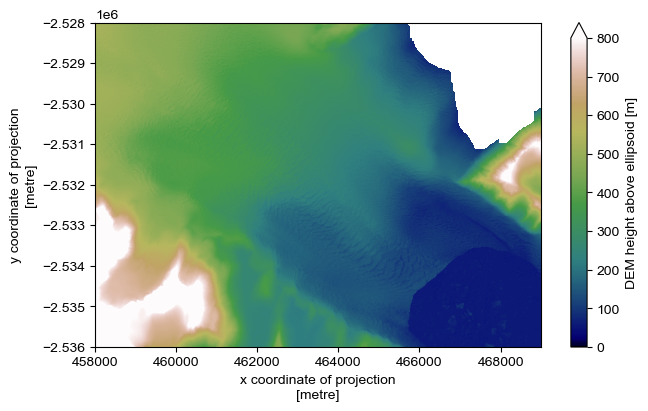

In [7]:
fig, ax = plt.subplots(figsize=(7,4))

dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})

ax.set_title(None)
ax.set_aspect('equal')


Looking good. You can see that the DEM has been automatically filtered using the ArcticDEM bitmask. You can change this by setting `bitmask` to `False` in the `load_aws()` function.

So as to avoid downloading the strip every time this notebook is run, you may wish to save a copy of the strip locally using `rioxarray` functions:


In [8]:
dem.rio.to_raster('example_dem.tif', compress='LZW')

CrevDEM has a `load_local()` function to retrieve this:

In [9]:
dem = crevdem.load_local('example_dem.tif')

If you are loading from a different local dataset that stores the bitmask elsewhere, you can provide a `bitmask_fpath` to `load_local()`, which will automatically filter the strip.

# Pre-processing the strip

There are a few different ways we might wish to preprocess the data. First off, we know there's no crevasses on land, so we can mask out bedrock regions using the `mask_bedrock()` function. You have two options with this functions:

1. Provide your own mask DataArray to this function as a `mask` variable (where regions to be retained are 1/True and the region to be masked are 0/False). The DataArray will be automatically resized to match the `dem` DataArray using `rioxarray`'s `reproject_match()` function and nearest neighbour resampling.
2. If you are interested in Greenland and have a local version of the GrIMP 15 m in a directory, you can point the function to this directory and it will extract bedrock locations for your AOI automatically.

Let's do the latter:

In [10]:
dem_filtered = crevdem.mask_bedrock(dem, grimp_mask_dir=grimp_dir)


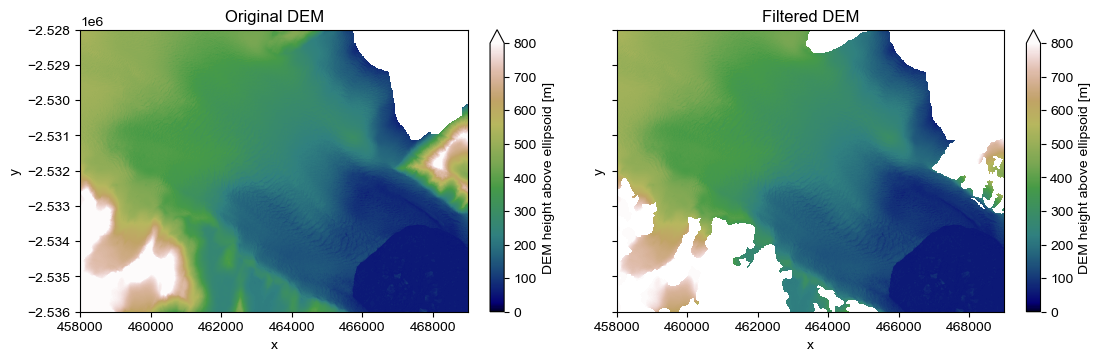

In [11]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(11,3.5))

ax = axes[0]
dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Original DEM')
ax.set_aspect('equal')

ax = axes[1]
dem_filtered.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Filtered DEM')
ax.set_aspect('equal')


This is nice, but it would also be useful to filter out regions of sea ice / mélange beyond the calving front. We can do this using a method adapted from Shiggins _et al._ (2023), who aimed to identify icebergs from ArcticDEM strips. In this method, sea level is estimated from a 0.25 m binned histogram of near-geoid values. 

Hence, we must first geoid-correct the strip, which can be done using the `geoid_correct()` function and pointing to a BedMachine dataset (either Greenland or Antarctica):

In [12]:
dem_filtered = crevdem.geoid_correct(dem_filtered, bedmachine_fpath=bedmachine_fpath)


We can then run the mélange finding method using `mask_melange()`. This functions estimates sea level relative to the geoid following Shiggins _et al._ 2023, before masking out all regions within 15 m of sea level (this default value can be changed using `near_sealevel_thresh_m`). If the strip does not have at least 1 km$^{2}$ of area  beneath 10 m, the DEM strip is considered to not contain ocean surface and is returned unmodified (these default values can be changed using `candidate_area_thresh_km2` and `candidate_height_thresh_m`).

In [13]:
dem_filtered = crevdem.mask_melange(dem_filtered)


It is worth noting there are two sub-functions here that have been left exposed to the user: the first is `get_melange_mask()`, which simply returns the mélange mask rather than the mélange-filtered DEM, and `get_sea_level()`, which simply returns the estimated sea level in the DEM strip. Both of these may be useful in alternative applications - for instance, in identifying icebergs follwing the original Shiggins _et al._ (2023) application. If the strip is considered to not contain ocean surface. `get_sea_level()` will return `None`.

Anyway, let's see what that has done:

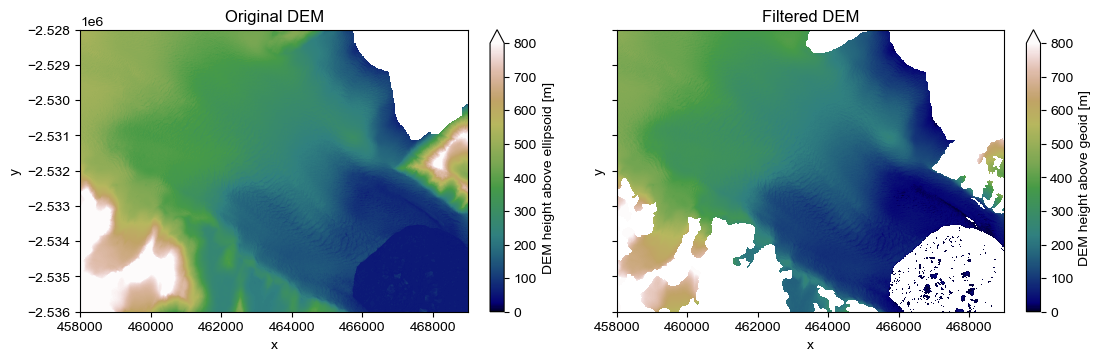

In [14]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(11,3.5))

ax = axes[0]
dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Original DEM')
ax.set_aspect('equal')

ax = axes[1]
dem_filtered.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above geoid [m]'})
ax.set_title('Filtered DEM')
ax.set_aspect('equal')


This workflow has been succesful in filtering the DEM to only glacier ice and a few icebergs (that will be largely ignored in the `crevdem` workflow, due to kernel size requirements).

# Applying CrevDEM

## The Quick Way

Applying the complete workflow with default variables is now a one-function job, using `find()`.

In [15]:
crev_depth = crevdem.find(dem_filtered, verbose=True)

Detrending... 0.3 s
Applying Black Top Hat filter... 1.4 s
Applying depth threshold... 0.1 s
Interpolating surface... 3.1 s
Calculating crevasse depth... 0.0 s
Finished


`verbose` outputs printed confirmations at each stage, to allow you to visualise progress on larger strips. 

By default, a DataArray of crevasse depths is produced, but you can also set `retain_intermediates` to `True` in order to to produce a DataSet containing the DEM, crevasse depth, and all intermediate arrays.

The output looks as follows:

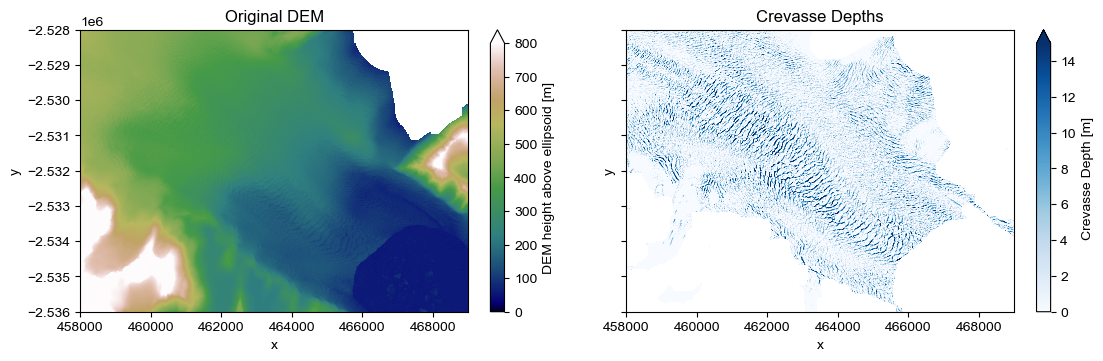

In [16]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(11,3.5))

ax = axes[0]
dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Original DEM')
ax.set_aspect('equal')

ax = axes[1]
crev_depth.plot(ax=ax, cmap='Blues', vmin=0, vmax=15, cbar_kwargs={'label': 'Crevasse Depth [m]'})
ax.set_title('Crevasse Depths')
ax.set_aspect('equal')

# plt.savefig('../images/crevdem_output.jpg', dpi=600)

## Individual Steps

`find` is a wrapper for a cascade of functions, each with their own tunable variables (these can be set within the `find` function as well - just see `help(crevdem.find)`. We will go through the individual steps here.

Before you begin, the most important variable is the `range`, a length scale sensitive to crevasse size and used during the black top hat filtering. This is set by default to 60 m, as assessed for marine-terminating glaciers on the Greenland Ice Sheet. See the `variogram_analysis.ipynb` notebook in this folder for more information as to how this value can be optimised.

In [17]:
range_m = 60  # range, in metres

### Detrending

Detrending is performed using a gaussian filter. The `find()` function sets the standard deviation of the gaussian filter to be, by default, 200 m, which is found to be appropriate for extracting high-frequency information at Greenlandic marine-terminating fronts (see `variogram_notebook.ipynb`). It can be changed using the `gauss_std_m` variable in `find()` (this is provided in metres, and will be converted to pixels automatically).

After detrending, we retain only the local variability:

In [18]:
dem_detrended = crevdem.detrend(dem_filtered, gauss_std_m=(range_m * 3))

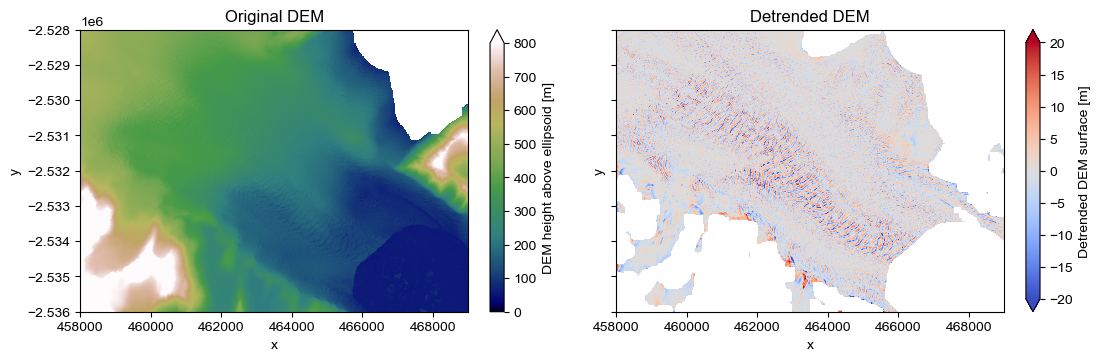

In [19]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(11,3.5))

ax = axes[0]
dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Original DEM')
ax.set_aspect('equal')

ax = axes[1]
dem_detrended.plot(ax=ax, cmap='coolwarm', vmin=-20, vmax=20, cbar_kwargs={'label': 'Detrended DEM surface [m]'})
ax.set_title('Detrended DEM')
ax.set_aspect('equal')


### Black Top Hat (BTH) filtering

We then apply a black top hat filter to the data. The black top hat filter is the difference between the _closing_ of the DEM (a dilation followed by an erosion) and the original DEM.

The BTH uses a disk-shaped kernel of a diamter set to `kernel_diameter_m`. In the `find()` workflow, this is set as the `range`.

In [20]:
bth = crevdem.bth_filter(dem_detrended, kernel_diameter_m=range_m)

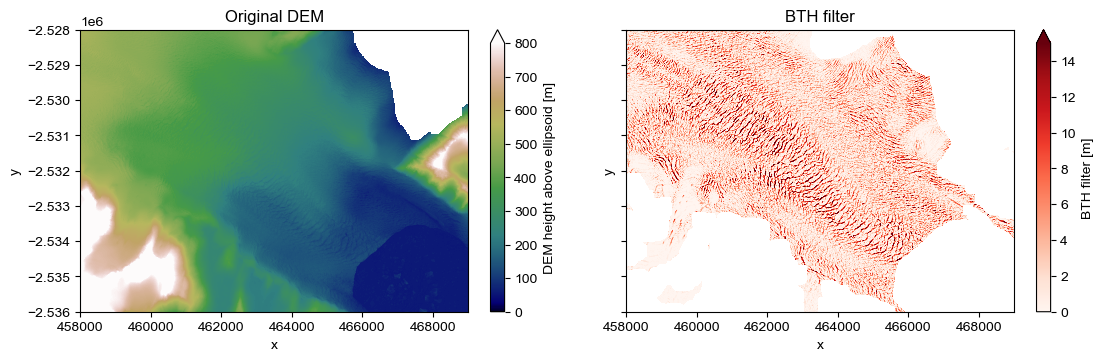

In [21]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(11,3.5))

ax = axes[0]
dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Original DEM')
ax.set_aspect('equal')

ax = axes[1]
bth.plot(ax=ax, cmap='Reds', vmax=15, cbar_kwargs={'label': 'BTH filter [m]'})
ax.set_title('BTH filter')
ax.set_aspect('equal')


### Threshold depth

We filter out low BTH values using a threshold, set as `depth_thresh_m`. In `find()`, this is set by default to 1. This produces a mask of crevasses.

In [22]:
crev_mask = crevdem.threshold_depth(bth, depth_thresh_m=1)

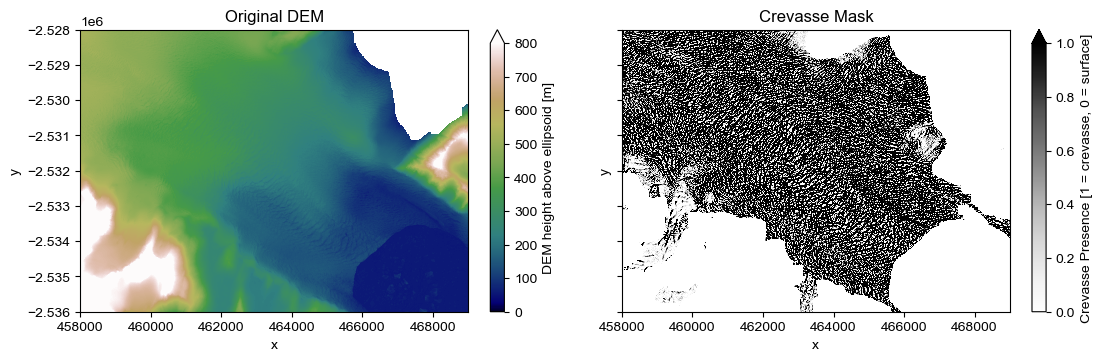

In [23]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(11,3.5))

ax = axes[0]
dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Original DEM')
ax.set_aspect('equal')

ax = axes[1]
bth.plot(ax=ax, cmap='Greys', vmin=0, vmax=1, cbar_kwargs={'label': 'Crevasse Presence [1 = crevasse, 0 = surface]'})
ax.set_title('Crevasse Mask')
ax.set_aspect('equal')


You'll notice that this produces a very messy surface with a lot of 'crevasses' identified. This is in part because we have chosen a very crevassed surface, and because of the aliasing involved in presenting a high-resolution image as a low-resolution figure. However, it is also because we are targeting depth/volume measurements rather than a binary mask: these are two different outputs that require different considerations. When quantifying crevasses as a depth rather than a binary presence, shallow false positives are a negligible error, so we aim to be inclusive. If you would like to output a mask, but require less sensitivity, you can increase the `depth_thresh_m`. This will introduce a stricter threshold on crevasse identification at the cost of artifically reducing the measured depth of crevasses. 

### Interpolate surface

To predict crevasse depth, we need a predicted surface (i.e. what the glacier surface would look like were all crevasses to be filled). The BTH surface is not appropriate for this. Instead, we take the crevasse mask and 'fill' using an inverse distance weighting function, followed by simple 3x3 smoothing operations (this the `rasterio` `fillnodata()` function, which is in turn a wrapper for the GDAL `FillNodata` function).

The only required input is the search distance (the distance into the masked region the IDW function searches, in pixels). This is set to 60 pixels in the default `find()` function.

In [24]:
dem_filled = crevdem.interpolate_surface(dem_filtered, crev_mask, search_dist_px=60)

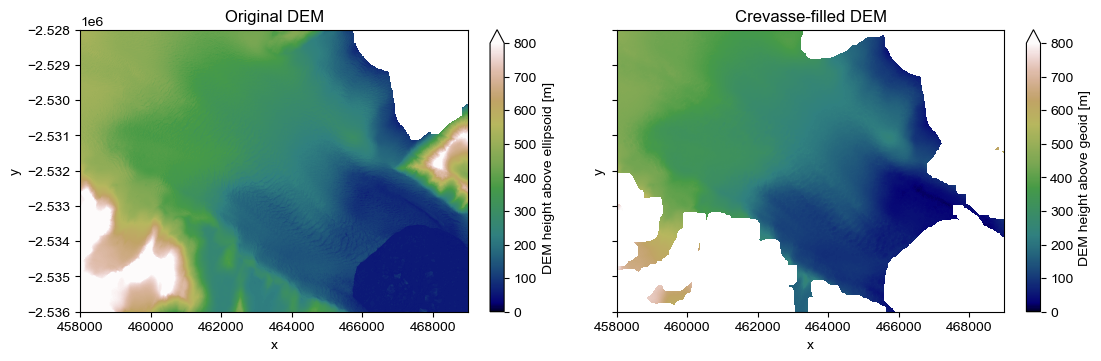

In [25]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(11,3.5))

ax = axes[0]
dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Original DEM')
ax.set_aspect('equal')

ax = axes[1]
dem_filled.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above geoid [m]'})
ax.set_title('Crevasse-filled DEM')
ax.set_aspect('equal')


### Get crevasse depth

Finally, a simple function calculates the difference between the raw DEM and the interpolated 'surface' to estimate crevasse depth:

In [26]:
crev_depth = crevdem.calc_depth(dem_filtered, dem_filled)

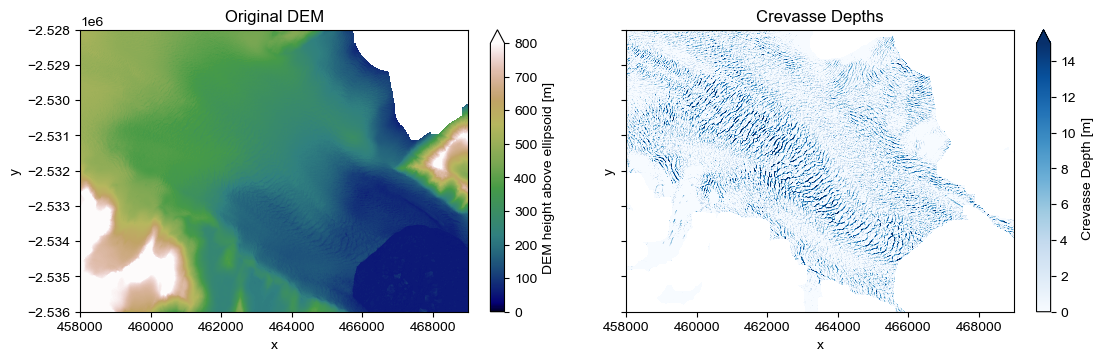

In [27]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(11,3.5))

ax = axes[0]
dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'DEM height above ellipsoid [m]'})
ax.set_title('Original DEM')
ax.set_aspect('equal')

ax = axes[1]
crev_depth.plot(ax=ax, cmap='Blues', vmin=0, vmax=15, cbar_kwargs={'label': 'Crevasse Depth [m]'})
ax.set_title('Crevasse Depths')
ax.set_aspect('equal')


## Profile visualisation

As an alternative visualisation, here is a comparison between the raw DEM surface and the 'filled' DEM.

(461000.0, 466000.0)

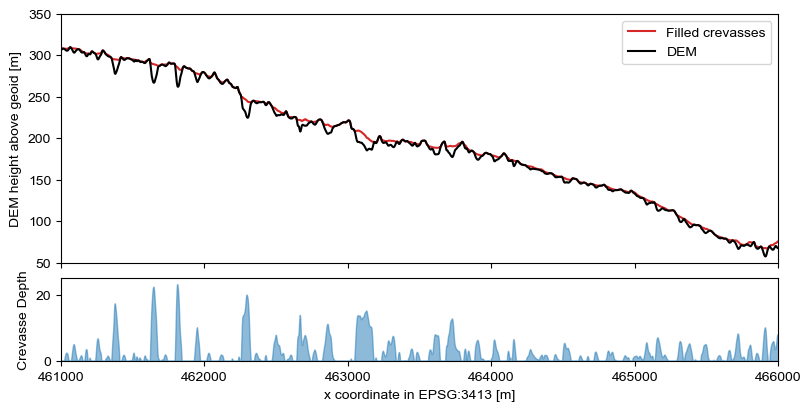

In [28]:
fig, axes = plt.subplots(nrows=2, sharex=True, height_ratios=[3,1], figsize=(8,4))

i = 2000
distance = dem.x.values

ax = axes[0]
ax.plot(distance, dem_filled.values[i,:], c='tab:red', label='Filled crevasses')
ax.plot(distance, dem_filtered.values[i,:], c='k', label='DEM')
ax.legend()
ax.set_ylabel('DEM height above geoid [m]')
ax.set_ylim(50, 350)

ax = axes[1]
ax.fill_between(distance, 0, crev_depth.values[2000,:], color='tab:blue', alpha=.5)
ax.set_ylabel('Crevasse Depth')
ax.set_ylim(0, 25)

ax.set_xlabel('x coordinate in EPSG:3413 [m]')
ax.set_xlim(461000, 466000)
